## Concepts Implemented
* Image Argumentation (Image normalization, Random Crop, Random Flip)
* Batch Nomalization
* Residual Networks (Implementation from scratch)


In [27]:
import os
import tarfile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,random_split
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# Dowload the dataset
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: ./cifar10.tgz
['test', 'train', 'labels.txt']
['horse', 'cat', 'ship', 'airplane', 'frog', 'automobile', 'bird', 'dog', 'deer', 'truck']


## Dataset and Dataloader

In [29]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [30]:
dataset = ImageFolder(data_dir+'/train', train_tfms)
test_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [31]:
val_split = 0.2
valid_size = int(len(dataset)*val_split)
train_size = len(dataset) - valid_size

train_ds,valid_ds = random_split(dataset,[train_size,valid_size])
len(train_ds), len(valid_ds)

(40000, 10000)

In [32]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)

## Visualising a Batch of data

In [33]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


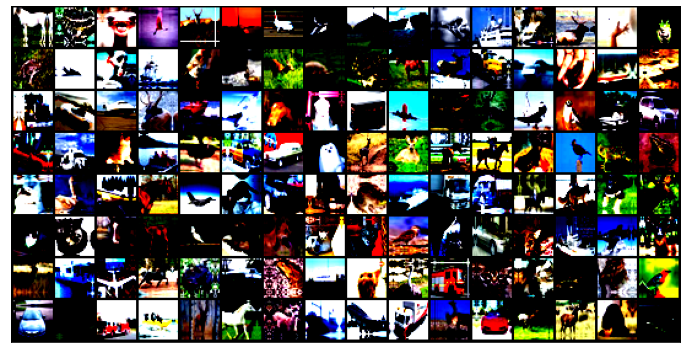

In [34]:
show_batch(train_dl)

## Using GPU

In [35]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [36]:
device = get_default_device()
device

device(type='cuda')

In [37]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

## Building Resnet9 Model

In [38]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['train_loss'], result['val_loss'], result['val_acc']))

In [39]:
in_channel = 3
num_classes = 10

In [40]:
def conv_block(in_channel,out_channel,pool=False):
  if pool==True:
    return nn.Sequential(
           nn.Conv2d(in_channel,out_channel,kernel_size=3,padding=1),
           nn.BatchNorm2d(out_channel),
           nn.ReLU(inplace=True),
           nn.MaxPool2d(2)
          )
  else:
       return nn.Sequential(
              nn.Conv2d(in_channel,out_channel,kernel_size=3,padding=1),
              nn.BatchNorm2d(out_channel),
              nn.ReLU(inplace=True)
             )
    

class Resnet9(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.conv1 = conv_block(in_channel,64)
    self.conv2 = conv_block(64,128,pool=True) # output = 128*16*16
    self.res1 = nn.Sequential(conv_block(128,128) , conv_block(128,128))
    self.conv3 = conv_block(128,256,pool=True) # output = 512*8*8
    self.conv4 = conv_block(256,512,pool=True) # output = 512*4*4
    self.res2 = nn.Sequential(conv_block(512,512) , conv_block(512,512))
    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Linear(512,num_classes)
                                    )
    
  def forward(self,xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out

In [41]:
model = to_device(Resnet9(), device)
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Traning and Evaluation

In [42]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [43]:
history = fit(10,0.001, model, train_dl, valid_dl, opt_func=torch.optim.Adam)

Epoch [0], train_loss: 1.2886, val_loss: 0.9710, val_acc: 0.6643
Epoch [1], train_loss: 0.7759, val_loss: 0.7635, val_acc: 0.7301
Epoch [2], train_loss: 0.6127, val_loss: 0.6709, val_acc: 0.7701
Epoch [3], train_loss: 0.5247, val_loss: 0.6854, val_acc: 0.7694
Epoch [4], train_loss: 0.4503, val_loss: 0.7169, val_acc: 0.7666
Epoch [5], train_loss: 0.4051, val_loss: 0.5175, val_acc: 0.8247
Epoch [6], train_loss: 0.3653, val_loss: 0.5933, val_acc: 0.8069
Epoch [7], train_loss: 0.3214, val_loss: 0.4568, val_acc: 0.8428
Epoch [8], train_loss: 0.3016, val_loss: 0.4210, val_acc: 0.8591
Epoch [9], train_loss: 0.2648, val_loss: 0.5156, val_acc: 0.8266


In [44]:
history += fit(5,0.001, model, train_dl, valid_dl, opt_func=torch.optim.Adam)

Epoch [0], train_loss: 0.2873, val_loss: 0.5421, val_acc: 0.8365
Epoch [1], train_loss: 0.2381, val_loss: 0.3921, val_acc: 0.8729
Epoch [2], train_loss: 0.2234, val_loss: 0.4466, val_acc: 0.8537
Epoch [3], train_loss: 0.2036, val_loss: 0.3921, val_acc: 0.8760
Epoch [4], train_loss: 0.1784, val_loss: 0.4931, val_acc: 0.8591


In [45]:
history += fit(5,0.001, model, train_dl, valid_dl, opt_func=torch.optim.Adam)

Epoch [0], train_loss: 0.1860, val_loss: 0.4740, val_acc: 0.8584
Epoch [1], train_loss: 0.1651, val_loss: 0.4123, val_acc: 0.8705
Epoch [2], train_loss: 0.1440, val_loss: 0.4760, val_acc: 0.8648
Epoch [3], train_loss: 0.1403, val_loss: 0.4257, val_acc: 0.8770
Epoch [4], train_loss: 0.1216, val_loss: 0.3774, val_acc: 0.8906


## Plotting Accuracy and Losses

In [46]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [47]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

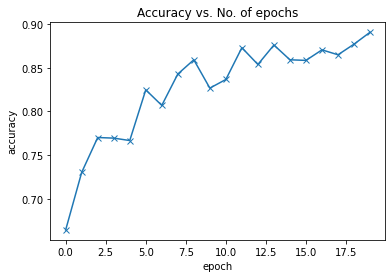

In [48]:
plot_accuracies(history)

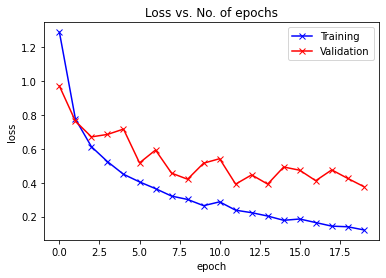

In [49]:
plot_losses(history)

## Evaluation of model on test data

In [50]:
evaluate(model,test_dl)

{'val_acc': 0.8981408476829529, 'val_loss': 0.35795506834983826}